# UFC ML Model Predictor

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

## Read and Clean Data for Use

In [5]:
raw = pd.read_csv('ufc-master.csv')
raw.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Elbows,3.0,0:39,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,Elbows,3.0,3:21,801.0,275.0,550.0,500.0,700.0,300.0,250.0


In [10]:
not_stat = raw.select_dtypes(['object']).columns
not_stat

Index(['RedFighter', 'BlueFighter', 'Date', 'Location', 'Country', 'Winner',
       'WeightClass', 'Gender', 'BlueStance', 'RedStance', 'BetterRank',
       'Finish', 'FinishDetails', 'FinishRoundTime'],
      dtype='object')

In [17]:
raw.drop(columns = ['RedFighter', 'BlueFighter', 'Date', 'Location', 'Country', 'Gender', 'BetterRank','Finish', 'FinishDetails', 'FinishRoundTime'], inplace = True)

In [18]:
raw.select_dtypes(['object']).columns

Index(['Winner', 'WeightClass', 'BlueStance', 'RedStance'], dtype='object')

In [19]:
stance_map = {'Orthodox': 0, 'Southpaw': 1, 'Switch': 2, 'Open Stance': 3}
raw['RedStance'] = raw['RedStance'].replace(stance_map)
raw['BlueStance'] = raw['BlueStance'].replace(stance_map)

win_map = {'Red': 1, 'Blue': 0}
raw['Winner'] = raw['Winner'].replace(win_map)
raw['Winner'].replace(np.nan, 2, inplace = True)

/var/folders/dd/1z0t59cd1yz727ndmzd5xk1h0000gn/T/ipykernel_28551/338885014.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw['RedStance'] = raw['RedStance'].replace(stance_map)
/var/folders/dd/1z0t59cd1yz727ndmzd5xk1h0000gn/T/ipykernel_28551/338885014.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw['Winner'] = raw['Winner'].replace(win_map)
/var/folders/dd/1z0t59cd1yz727ndmzd5xk1h0000gn/T/ipykernel_28551/338885014.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assi

In [21]:
raw['Winner'].unique()
raw['Winner'].value_counts()

Winner
1    3787
0    2741
Name: count, dtype: int64

In [22]:
x = raw.drop(columns = ['Winner'])
y = raw['Winner']

In [24]:
def fill_nan_by_weight(df):
    df_new = df.copy()
    numeric_cols = df_new.select_dtypes(include=[np.number]).columns
    df_new = df_new.groupby('WeightClass')[numeric_cols].transform(lambda x: x.fillna(x.mean()))

    remaining = df_new[numeric_cols].isna().sum().sum()
    if remaining > 0:
        df_new[numeric_cols] = df_new[numeric_cols].fillna(df_new[numeric_cols].mean())

    return df_new

x_filled = fill_nan_by_weight(x)

x_filled.replace(np.nan, 0, inplace = True)

x = x_filled.select_dtypes(include=[np.number])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [26]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5222, 104) (1306, 104) (5222,) (1306,)


In [27]:
seed = 360
np.random.seed(seed)

In [31]:
from sklearn.preprocessing import StandardScaler   

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Initialize and Test Models

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
kfold_lr = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
cv_lr = cross_val_score(lr, x_train, y_train, cv=kfold_lr)
lr_score = cv_lr.mean()

lr.fit(x_train, y_train)

print('Logistic Regression cross validation score:', lr_score)
print('Logistic Regression mean score:', lr_score)

Logistic Regression cross validation score: 0.6524318146853916
Logistic Regression mean score: 0.6524318146853916


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
kfold_rf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
cv_rf = cross_val_score(rf, x_train, y_train, cv=kfold_rf)
rf_score = cv_rf.mean()

rf.fit(x_train, y_train)

print('Random Forest cross validation score:', cv_rf)
print('Random Forest mean score:', rf_score)

Logistic Regression cross validation score: [0.66730402 0.65391969 0.63984674 0.63984674 0.66283525 0.68007663
 0.63218391 0.67241379 0.62643678 0.66091954]
Logistic Regression mean score: 0.6535783096342206


### K-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
kfold_knn = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
cv_knn = cross_val_score(knn, x_train, y_train, cv=kfold_knn)
knn_score = cv_knn.mean()

knn.fit(x_train, y_train)  

print('KNN cross validation score:', cv_knn)
print('KNN mean score:', knn_score)

KNN cross validation score: [0.59847036 0.56022945 0.58237548 0.57088123 0.61302682 0.57854406
 0.60536398 0.59195402 0.57854406 0.56321839]
KNN mean score: 0.5842607854772423


### Decision Tree

In [36]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(random_state=seed)
kfold_dt = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
cv_dt = cross_val_score(dt, x_train, y_train, cv=kfold_dt)
dt_score = cv_dt.mean()

print('Decision Tree cross validation score:', cv_dt)
print('Decision Tree mean score:', dt_score)


Decision Tree cross validation score: [0.58126195 0.58508604 0.56321839 0.59578544 0.53639847 0.5862069
 0.58429119 0.56704981 0.53831418 0.57662835]
Decision Tree mean score: 0.5714240712658331


### Neural Network

In [73]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [74]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [75]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)  

In [76]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [77]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super(NN, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 2)

        self.dropout = nn.Dropout(0.2)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128) 
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(32)

    def forward(self, x):
        
        x = F.relu(self.layer1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.relu(self.layer2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.relu(self.layer3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        
        x = F.relu(self.layer4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.output(x)

        return F.log_softmax(x, dim = 1)

In [78]:
model = NN(x_train_tensor.shape[1])

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [80]:
def train_nn(model, x_train, y_train, epochs, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            output = model(x_batch)
            loss = criterion(output, y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)

        if epoch % 100 == 0:
            print(f'Epoch {epoch} Loss {avg_loss}')

    return train_losses

In [81]:
def eval_nn(model, x_test, y_test, batch_size, criterion):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()

    test_loss = 0
    batch_count = 0
    predictions = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            output = model(x_batch)
            loss = criterion(output, y_batch)

            test_loss += loss.item()
            batch_count += 1

            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())

        avg_loss = test_loss / batch_count
        print(f'Average Loss {avg_loss:.4f}')

    return avg_loss, predictions

In [82]:
def accuracy(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        _, predicted = torch.max(outputs, 1)

        accuracy = (predicted == y_test).sum().item() / len(y_test)
        return accuracy

In [87]:
def predict(model, x_test):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        _, predicted = torch.max(outputs, 1)
        return predicted

In [83]:
train_model = train_nn(model, x_train_tensor, y_train_tensor, 500, 64)

Epoch 0 Loss 0.6679171592724032
Epoch 100 Loss 0.1466564867736363
Epoch 200 Loss 0.09179180565222007
Epoch 300 Loss 0.0651021230761416
Epoch 400 Loss 0.05602288159269204


In [84]:
val_model = eval_nn(model, x_test_tensor, y_test_tensor, 32, criterion)

Average Loss 1.9188


In [85]:
score = accuracy(model, x_test_tensor, y_test_tensor)
print('Neural Network accuracy:', score)

Neural Network accuracy: 0.5949464012251149


In [86]:
scores = [['Logistic Regression', lr_score], ['Random Forest', rf_score], ['KNN', knn_score], ['Decision Tree', dt_score], ['Neural Network', score]]
scores = pd.DataFrame(scores, columns = ['Model', 'Score'])
scores

,Model,Score
0,Logistic Regression,0.652432
1,Random Forest,0.653578
2,KNN,0.584261
3,Decision Tree,0.571424
4,Neural Network,0.594946


## Confusion Matrix Plots

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Logistic Regression Plot

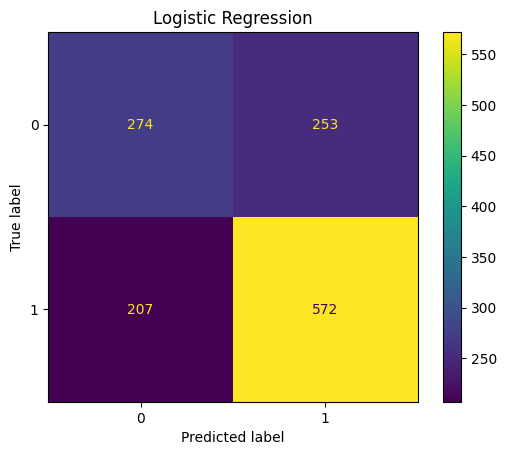

In [89]:
y_pred_lr = lr.predict(x_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
disp_lr.ax_.set_title('Logistic Regression')
plt.show()

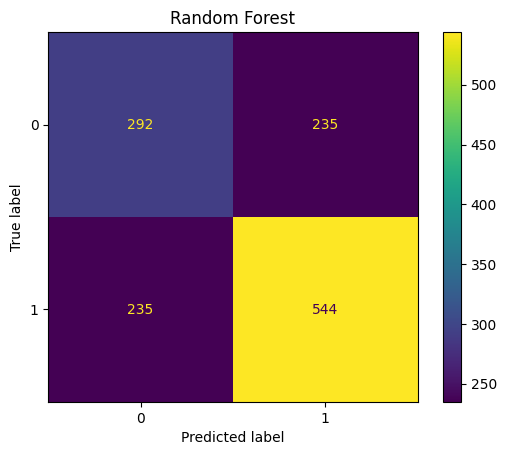

In [90]:
y_pred_rf = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
disp_rf.ax_.set_title('Random Forest')
plt.show()

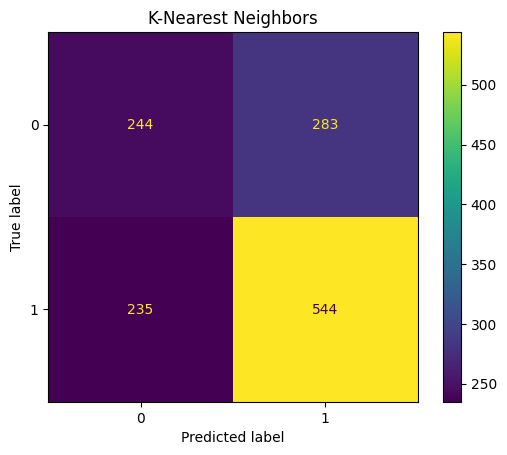

In [91]:
y_pred_knn = knn.predict(x_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()
disp_knn.ax_.set_title('K-Nearest Neighbors')
plt.show()

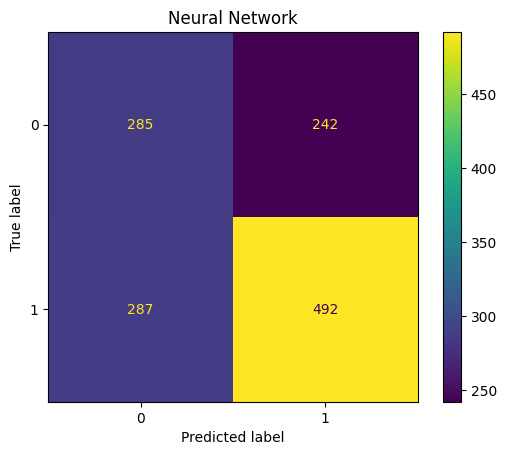

In [92]:
y_pred_nn = predict(model, x_test_tensor)
cm_nn = confusion_matrix(y_test_tensor, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot()
disp_nn.ax_.set_title('Neural Network')
plt.show()